<a href="https://colab.research.google.com/github/akash1003/SVD-Homography-Computation/blob/main/SVD_Homography_Computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applying SVD to compute homography

In this lab, we will implement the Direct Linear Transform (pg 91, Algorithm 4.1, Hartley-Zisserman Text on Multi-view Geometry)

You are given an image with a chess board used for calibration. Also given are the correpondence points between the real chessboard and image coordinates.
You need to calculate the homography to map the image of the chessboard with the actual chessboard.

You will compare your homography with that provided by openCV


In [ ]:
import numpy as np
#open CV library for image manipulation
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
#allows for downloading of files from internet
import urllib.request

In [ ]:
#download one image which has a chessboad
urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/opencv/opencv/3.4/samples/data/left12.jpg', "left04.jpg"
    )


('left04.jpg', <http.client.HTTPMessage at 0x7f18b6e138d0>)

In [ ]:
#camera parameters for the camera used in capturing the above image
#(from: https://github.com/opencv/opencv/blob/3.4/samples/data/left_intrinsics.yml)
#intrinsic parameters 
cameraMatrix = np.array(
    [
      [5.3591573396163199e+02, 0., 3.4228315473308373e+02,],
      [0.,5.3591573396163199e+02, 2.3557082909788173e+02],
      [0.,0.,1.]
    ]
)
#distortion coefficients
distCoeffs=np.array(
    [-2.6637260909660682e-01, -3.8588898922304653e-02,
       1.7831947042852964e-03, -2.8122100441115472e-04,
       2.3839153080878486e-01]
)

#square size used in the chess board 
squareSize=2.5 #cm
distance = 26.8 #cm approximate distance of board from camera

Image size =  (480, 640, 3)


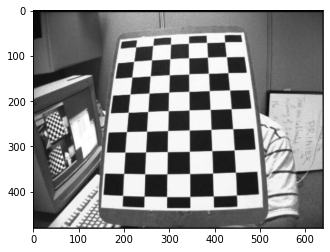

In [ ]:
img = cv.imread('left04.jpg')
print("Image size = ", img.shape)
plt.imshow(img)

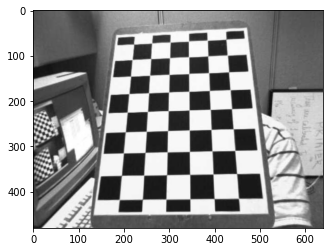

In [ ]:
# remove the radial distortion due to the camera lens
img_undistort = cv.undistort(img, cameraMatrix, distCoeffs)
plt.imshow(img_undistort)


#Note that in images, the x-axes goes from left to right, 
#while the y goes from top to bottom
#origin is top left

In [ ]:
#utility function to get the in-homogenous cordinates 
#by dividing by the last coordinate value
def ToHom (v,tol=1e-3):
  '''Convert to homogenous coordinates.
     input: v, mxn array, with last row used for homogenization
  '''
  if len(v.shape) > 2 :
    raise Exception("Sorry - only upto 2-D arrays allowed")
  m = v[-1,...]
  return np.divide(v, np.where(np.abs(m)> tol,m,1))

In [ ]:
#Set up the 3D world coordinates of the 6x7 corner points of the squares in the chessboard
# The chess board is assumed to be "distance" away from the camera
# map the center of the chess board to the center of the camera
nx=6
ny=7
z = np.ones((ny*nx,3), dtype=np.float32)
wCx,wCy = 3,4
for ix in range(nx):
  for jy in range(ny):
    z[ny*ix+jy]=[(ix-wCx)*squareSize,-(jy-wCy)*squareSize,distance]

#print(z)

#Now image this onto the camera (with optical axis normal to chessboard to )
y = cameraMatrix @ z.T
#print(y.T[0:4,:])
yh = ToHom(y).T
print("first few coner point coordinates ")
print(yh[0:4,:])

first few coner point coordinates 
[[192.30673238 435.53939224   1.        ]
 [192.30673238 385.54725145   1.        ]
 [192.30673238 335.55511067   1.        ]
 [192.30673238 285.56296988   1.        ]]


(42, 1, 2) [[[196.31808 364.50308]]

 [[200.05263 315.52026]]

 [[204.91032 268.33215]]

 [[209.28091 225.64786]]]


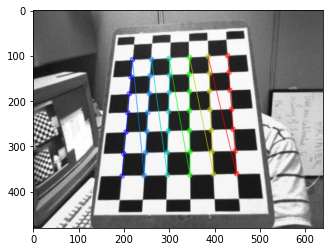

In [ ]:
#find the corner points from the image in the image plane coordinates
gray = cv.cvtColor(img_undistort, cv.COLOR_BGR2GRAY)
ret, corners = cv.findChessboardCorners(gray,(7,6),None)
#print(ret)
print(corners.shape, corners[0:4,...])

#put the detected corner points onto the image 
cv.drawChessboardCorners(img_undistort, (7,6), corners, ret)
plt.imshow(img_undistort)

In [ ]:
H_cv, mask = cv.findHomography(corners.reshape(-1,2), yh[:,0:2])
print(H_cv)

[[ 1.42902698e+00  3.07361065e-01 -1.27521189e+02]
 [ 9.86333482e-02  1.74974526e+00 -5.91289202e+01]
 [ 1.73373090e-04  9.32901443e-04  1.00000000e+00]]


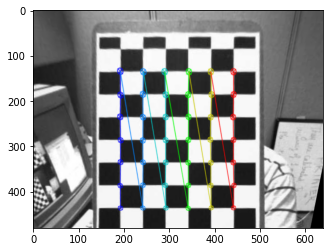

In [ ]:
img_unwarp_cv = cv.warpPerspective(img_undistort,H_cv ,dsize=(640,480))
plt.imshow(img_unwarp_cv)

In [ ]:
# Your code here

#convert the image points to homogenous form (with 3 components)
u=corners.reshape(-1,2)
v = np.ones((u.shape[0],3))
v[:,0:2] = u
pts = u.shape[0]
#Now build the A matrix - Equation 4.3 in text
A = np.zeros((2*pts,9),dtype=np.float32)

for i in range(0,pts):
  #your code here
  x= v[i][0] 
  y= v[i][1]
  xdash=yh[i][0]
  ydash=yh[i][1]

  A[2*i][:] = [-x, -y,-1,0,0,0,x*xdash,y*xdash,xdash]
  #print(A[i][:])
  A[2*i+1][:]=  [0,0,0,-x,-y,-1,x*ydash,y*ydash,ydash]

#print(A)

difference = 141.58480929346533


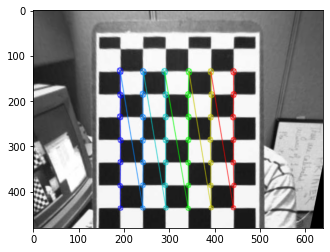

In [ ]:
#find the homography
#your code here
U,s,Vt = np.linalg.svd(A)
H_mine=Vt[-1].reshape(3,3)
#use this to un warp the image
img_unwarp_mine = cv.warpPerspective(img_undistort,H_mine ,dsize=(640,480))
plt.imshow(img_unwarp_mine)
#find the difference in your matrix with the one computed from CV
print('difference =', np.linalg.norm(H_cv-H_mine))